# NLP Tweet Classification

In this notebook we seek to build a model to detect disaster-related tweets.

A common NLP task is to classify text. The most common text classification is done in sentiment analysis, where texts are classified as positive or negative. In this section, we will consider a slightly harder problem, classifying whether a tweet is about an actual disaster happening or not.

Today, investors have developed a number of ways to gain information from tweets. Twitter users are often faster than news outlets to report disasters, such as a fire or a flood. In the case of finance, this speed advantage can be used and translated to event-driven trading strategies.

However, not all tweets that contain words associated with disasters are actually about disasters. A tweet such as, "California forests on fire near San Francisco" is a tweet that should be taken into consideration, whereas "California this weekend was on fire, good times in San Francisco" can safely be ignored.

The goal of the task here is to build a classifier that separates the tweets that relate to real disasters from irrelevant tweets. The dataset that we are using consists of hand-labeled tweets that were obtained by searching Twitter for words common to disaster tweets such as "ablaze" or "fire."

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import bespoke functions (plot_confusion_matrix, get_most_important_features, plot_important_words),
from Helpful_Functions import *

Preparing the text is a task in its own right. This is because in the real world, text is often messy and cannot be fixed with a few simple scaling operations. For instance, people can often make typos after adding unnecessary characters as they are adding text encodings that we cannot read. NLP involves its own set of data cleaning challenges and techniques.

Sanitizing characters
To store text, computers need to encode the characters into bits. There are several different ways to do this, and not all of them can deal with all the characters out there.

It is good practice to keep all the text files in one encoding scheme, usually UTF-8, but of course, that does not always happen. Files might also be corrupted, meaning that a few bits are off, therefore rendering some characters unreadable. Therefore, before we do anything else, we need to sanitize our inputs.

Our data is UTF-8 encoded, but there are a few special characters in there that cannot be read easily. Therefore, we have to sanitize our text of these special characters, which we can do by running the following:

In [2]:
#Clean the raw tweets .csv datafile and write a clean .csv datafile by taking into account the encoding

input_file = open('./socialmedia-disaster-tweets-DFE.csv','r', encoding='utf-8', errors='replace')
output_file =open('clean_socialmedia-disaster.csv', 'w', encoding="utf-8")
    
for line in input_file:
    out = line
    output_file.write(line)

input_file.close()
output_file.close()

In the preceding code, codecs.open acts as a stand-in replacement for Python's standard file opening function. It returns a file object, which we can later read line by line. We specify the input path that we want to read the file (with r), the expected encoding, and what to do with errors. In this case, we are going to replace the errors with a special unreadable character marker.

To write to the output file, we can just use Python's standard open() function. This function will create a file at the specified file path we can write to:

In [3]:
#Read clean .csv datafile with pandas
#df = pd.read_csv('clean_socialmedia-disaster.csv')
df = pd.read_csv('clean_socialmedia-disaster.csv')

In [4]:
#Overview of the data
df.head(50)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.000000e+00,NaN
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.300000e+01,NaN
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",1.400000e+01,NaN
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",1.500000e+01,NaN
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.600000e+01,NaN
5,778243828,True,golden,140,NaN,Relevant,1.0000,Relevant,NaN,NaN,All residents asked to 'shelter in place' are ...,1.700000e+01,NaN
6,778243831,True,golden,142,NaN,Relevant,1.0000,Relevant,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.800000e+01,NaN
7,778243832,True,golden,151,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.900000e+01,NaN
8,778243833,True,golden,143,NaN,Relevant,1.0000,Relevant,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,2.000000e+01,NaN
9,778243834,True,golden,136,NaN,Relevant,0.9606,Relevant\r\nCan't Decide,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,2.100000e+01,NaN


In [5]:
#Shape of the dataframe
df.shape

(10876, 13)

In [6]:
#Possible labels
df.choose_one.unique()

array(['Relevant', 'Not Relevant', "Can't Decide"], dtype=object)

<AxesSubplot:>

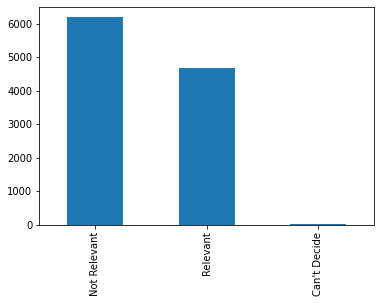

In [7]:
#`Labels frequency
df['choose_one'].value_counts().plot(kind='bar')

In [8]:
# Remove rows that contain "Can't Decide" labels from the dataset
df = df[df.choose_one != "Can't Decide"]

In [9]:
# Dataset size
df.shape

(10860, 13)

In [10]:
# Only keep relevant feature and label
df = df[['text','choose_one']]

In [11]:
# Overview of the dataframe
df.head()

,text,choose_one
0,Just happened a terrible car crash,Relevant
1,Our Deeds are the Reason of this #earthquake M...,Relevant
2,"Heard about #earthquake is different cities, s...",Relevant
3,"there is a forest fire at spot pond, geese are...",Relevant
4,Forest fire near La Ronge Sask. Canada,Relevant


In [12]:
# Mapping label
df['relevant'] = df.choose_one.map({'Relevant':1,'Not Relevant':0})

In [13]:
# Overview of the dataframe
df.head()

,text,choose_one,relevant
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


## Lemmatization

A lemma in the field of linguistics, also called a headword, is the word under which the set of related words or forms appears in a dictionary. For example, "was" and "is" appear under "be," "mice" appears under "mouse," and so on. Quite often, the specific form of a word does not matter very much, so it can be a good idea to convert all your text into its lemma form.

spaCy offers a handy way to lemmatize text, so once again, we're going to load a spaCy pipeline. Only that in this case, we don't need any pipeline module aside from the tokenizer. The tokenizer splits the text into separate words, usually by spaces. These individual words, or tokens, can then be used to look up their lemma. In our case, it looks like this:

In [17]:
!pip install spacy
import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en_core_web_sm

  Using cached spacy-3.2.2-cp310-cp310-win_amd64.whl (11.3 MB)

ERROR: Could not install packages due to an OSError: [WinError 2] El sistema no puede encontrar el archivo especificado: 'C:\\Python310\\Scripts\\spacy.exe' -> 'C:\\Python310\\Scripts\\spacy.exe.deleteme'



2022-02-19 11:42:47.636985: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-02-19 11:42:47.638143: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



     --------------------------------------- 13.9/13.9 MB 11.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [15]:
# Overview of the dataframe
df.head()

,text,choose_one,relevant
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [18]:
import spacy
nlp = spacy.load('en_core_web_sm',disable=['tagger','parser','ner'])

Lemmatization can be slow, especially for big files, so it makes sense to track our progress. tqdm allows us to show progress bars on the pandas apply function. All we have to do is import tqdm as well as the notebook component for pretty rendering in our work environment. We then have to tell tqdm that we would like to use it with pandas. We can do this by running the following:

In [19]:
# ...
from tqdm import tqdm, tqdm_notebook #same slide or another slide: tqdm is utility that gives a progress bar
tqdm.pandas()

We can now run progress_apply on a DataFrame just as we would use the standard apply method, but here it has a progress bar.

For each row, we loop over the words in the text column and save the lemma of the word in a new lemmas column:

In [20]:
# Add column with lemmatized text
df['lemmas'] = df["text"].progress_apply(lambda row: 
                                         [w.lemma_ for w in nlp(row)])

  0%|          | 0/10860 [00:00<?, ?it/s]C:\Python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 10860/10860 [01:02<00:00, 173.42it/s]


In [21]:
# Overview of the dataframe
df['lemmas']

0                [just, happened, a, terrible, car, crash]
1        [our, deeds, are, the, reason, of, this, #, ea...
2        [heard, about, #, earthquake, is, different, c...
3        [there, is, a, forest, fire, at, spot, pond, ,...
4         [forest, fire, near, la, ronge, sask, ., canada]
                               ...                        
10871    [m1.94, [, 01:04, utc]?5, km, s, of, volcano, ...
10872    [police, investigating, after, an, e, -, bike,...
10873    [the, latest, :, more, homes, razed, by, north...
10874    [meg, issues, hazardous, weather, outlook, (, ...
10875    [#, cityofcalgary, has, activated, its, munici...
Name: lemmas, Length: 10860, dtype: object

In [22]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['tweet_without_stopwords'] = df['lemmas'].apply(lambda x: ' '.join([word for word in x if word not in (stop)]))
df['tweet_without_stopwords'] = df['tweet_without_stopwords'].replace({'#':''}, regex=True)
df['tweet_without_stopwords'] = df['tweet_without_stopwords'].str.replace(r'[^\w\s]+', '')

C:\Users\apala\AppData\Local\Temp\ipykernel_26400\2966339610.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tweet_without_stopwords'] = df['tweet_without_stopwords'].str.replace(r'[^\w\s]+', '')


In [23]:
# Overview of the dataframe
df['tweet_without_stopwords']

0                              happened terrible car crash
1            deeds reason  earthquake may allah forgive us
2        heard  earthquake different cities  stay safe ...
3        forest fire spot pond  geese fleeing across st...
4                   forest fire near la ronge sask  canada
                               ...                        
10871    m194  0104 utc5 km volcano hawaii  httptcozdto...
10872    police investigating e  bike collided car litt...
10873    latest  homes razed northern california wildfi...
10874    meg issues hazardous weather outlook  hwo  htt...
10875     cityofcalgary activated municipal emergency p...
Name: tweet_without_stopwords, Length: 10860, dtype: object

In [24]:
# Add column with joint lemmatized text
#df['joint_lemmas'] = df['tweet_without_stopwords'].progress_apply(lambda row: [w.lemma_ for w in nlp(row)])

In [25]:
#df['joint_lemmas']

## Bag of Words

You have already seen that a simple yet effective way of classifying text is to see the text as a bag-of-words. This means that we do not care for the order in which words appear in the text, instead we only care about which words appear in the text.

One of the ways of doing a bag-of-words classification is by simply counting the occurrences of different words from within a text. This is done with a so-called count vector. Each word has an index, and for each text, the value of the count vector at that index is the number of occurrences of the word that belong to the index

In [26]:
# Define train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['tweet_without_stopwords'], 
                                                    df['relevant'], 
                                                    test_size=0.2,
                                                    random_state=42)

In reality, count vectors are pretty sparse. There are about 23,000 different words in our text corpus, so it makes sense to limit the number of words we want to include in our count vectors. We are using sklearn's built-in count vectorizer. By setting max_features, we can control how many words we want to consider in our count vector. In this case, we will only consider the 10,000 most frequent words:

In [27]:
# Define Bag of Words model with the 10,000 more frequent words
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_features=10000)
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

Once we have obtained our count vectors, we can then perform a simple logistic regression on them. While we could use Keras for logistic regression, as we did in the first chapter of this book, it is often easier to just use the logistic regression class from scikit-learn:

In [28]:
# X_train_counts size
X_train_counts.shape

(8688, 10000)

### Reminder of Logistic Regression: $log(P(Y=1)/(P(Y=0))=\beta_0 +\displaystyle\sum_{i=1}^{5000} \beta_i X_i$

### Brainteasers: 

1) Assume $\beta_0=-3$. How do you interpret this? 

2) Assume $\beta_1=3$. How do you interpret this?

3) Assume $\beta_{498}=2$. How do you interpret this?

4) How can we quantify the words that have the most impact on the probability that a tweet is relevant?

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
clf = LogisticRegression()

clf.fit(X_train_counts, y_train)

y_predicted = clf.predict(X_test_counts)

In [30]:
accuracy_score(y_test, y_predicted)

0.7965009208103131

As you can see, we've got 80% accuracy, which is pretty decent for such a simple method. A simple count vector-based classification is useful as a baseline for more advanced methods, which we will be discussing later.

In [31]:
from sklearn.metrics import confusion_matrix

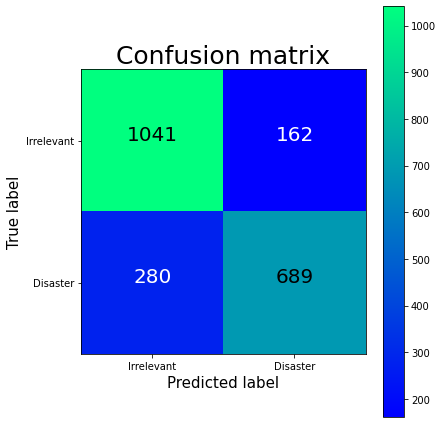

[[1041  162]
 [ 280  689]]


In [32]:
#BoW confusion matrix
cm = confusion_matrix(y_test, y_predicted)
fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

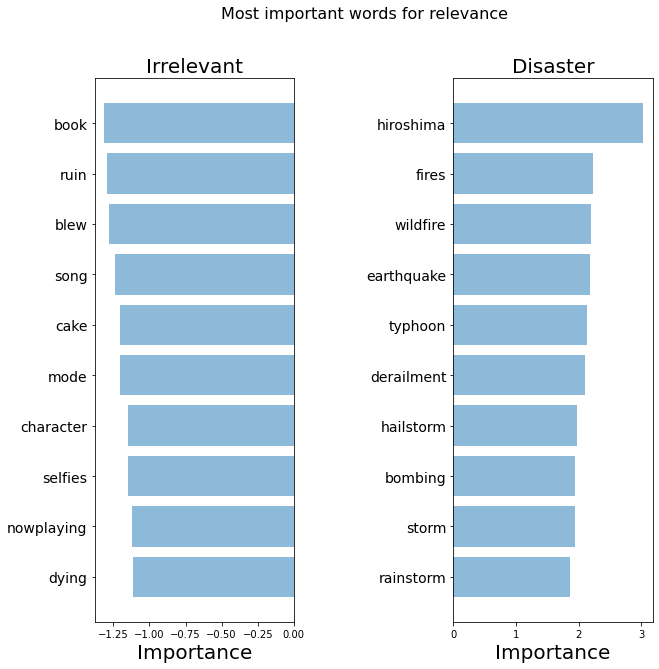

In [33]:
# Use bespoke function to determine the most important words, i.e. the words with highest coefficients in 
# the logistic regression
importance = get_most_important_features(count_vectorizer, clf, 10)

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

# Plot the most frequent words 
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

## Tf-idf

We now try using TF-IDF vectors to predict disasters.

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

We use a logistic regression model.

In [35]:
clf_tfidf = LogisticRegression()
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

The accuracy is quite good. 

In [36]:
accuracy_score(y_pred=y_predicted_tfidf, y_true=y_test)

0.7955801104972375

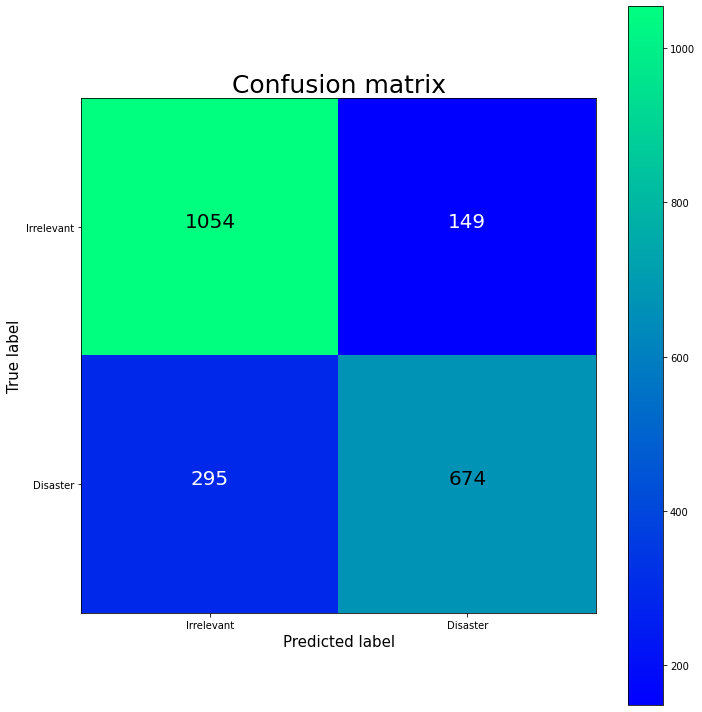

TFIDF confusion matrix
[[1054  149]
 [ 295  674]]


In [37]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)

In [38]:
# Use bespoke function to determine the most important words, i.e. the words with highest coefficients in 
# the logistic regression

importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

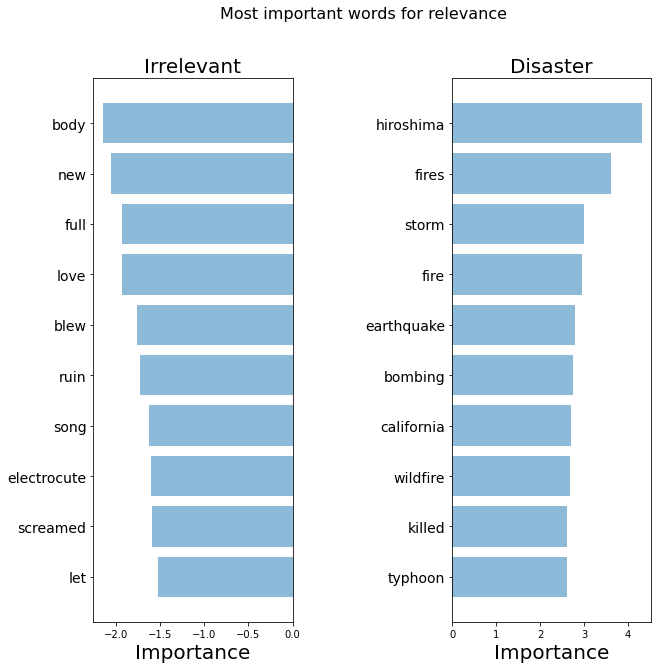

In [39]:
# Plot the 10 most important words

top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

## Word Embedding

The order of words in a text matters. Therefore, we can expect higher performance if we do not just look at texts in aggregate but see them as a sequence. This section makes use of a lot of the techniques discussed earlier; however, here we're going to add a critical ingredient, word vectors.

Words and word tokens are categorical features. As such, we cannot directly feed them into a neural network. Previously, we have dealt with categorical data by turning it into one-hot encoded vectors. Yet for words, this is impractical. Since our vocabulary is 10,000 words, each vector would contain 10,000 numbers that are all zeros except for one. This is highly inefficient, so instead, we will use an embedding.

In practice, embeddings work like a lookup table. For each token, they store a vector. When the token is given to the embedding layer, it returns the vector for that token and passes it through the neural network. As the network trains, the embeddings get optimized as well.

Remember that neural networks work by calculating the derivative of the loss function with respect to the parameters (weights) of the model. Through backpropagation, we can also calculate the derivative of the loss function with respect to the input of the model. Thus we can optimize the embeddings to deliver ideal inputs that help our model.

Preprocessing for training with word vectors
Before we start with training word embeddings, we need to do some preprocessing steps. Namely, we need to assign each word token a number and create a NumPy array full of sequences.

Assigning numbers to tokens makes the training process smoother and decouples the tokenization process from the word vectors. Keras has a Tokenizer class, which can create numeric tokens for words. By default, this tokenizer splits text by spaces. While this works mostly fine in English, it can be problematic and cause issues in other languages. A key learning point to take away is that it's better to tokenize the text with spaCy first, as we already did for our two previous methods, and then assign numeric tokens with Keras.

The Tokenizer class also allows us to specify how many words we want to consider, so once again we will only use the 10,000 most used words, which we can specify by running:

In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

max_words = 10000 # We will only consider the 10K most used words in this dataset

The tokenizer works a lot like CountVectorizer from sklearn. First, we create a new tokenizer object. Then we fit the tokenizer, and finally, we can transform the text into tokenized sequences:

In [41]:
# Setup
tokenizer = Tokenizer(num_words=max_words) 

# Generate tokens by counting frequency
tokenizer.fit_on_texts(df['tweet_without_stopwords']) 

# Turn text into sequence of numbers
sequences = tokenizer.texts_to_sequences(df['tweet_without_stopwords']) 

In [42]:
print(sequences)

[[681, 1384, 58, 32], [5666, 721, 156, 73, 1663, 3639, 14], [277, 156, 1174, 1664, 542, 1300, 157], [93, 6, 699, 2371, 8441, 4388, 772, 571, 267], [93, 6, 122, 682, 8442, 8443, 1175], [1462, 1385, 1962, 633, 8444, 1665, 182, 1962, 633, 1555, 1126], [3061, 13, 4389, 1176, 182, 1555, 37], [27, 1386, 193, 5667, 1806, 190, 1176, 8445, 123], [3062, 310, 37, 1807, 543, 773, 8446, 311, 1127, 312, 6, 5668, 1176], [268, 3063, 5669, 1176], [118, 19, 774, 209, 986, 775, 201, 1666, 8447, 987, 2655, 1463], [134, 614, 249, 2656, 210, 1128], [24, 3640, 2, 156], [7, 135, 2129, 44, 6, 4390], [2, 16, 182, 1129, 487, 772, 571], [7, 2130, 451, 161, 226], [361, 13, 436, 168, 298, 498], [802, 467, 2657, 150, 2658, 4391, 580, 561, 115, 467, 2657, 3064, 3064, 8448, 201], [3641, 201, 1556, 8449, 2657, 1035, 931, 522, 72, 722, 3642], [118, 5670, 862, 1464, 5670], [169, 123, 387, 2372, 3065, 58, 32, 269], [162, 655, 23, 202, 55, 2373, 904, 2374, 2374], [723], [2, 40], [49, 5671], [163, 1557], [58, 751], [1073, 5

The sequences variable now holds all of our texts as numeric tokens. We can look up the mapping of words to numbers from the tokenizer's word index with the following code:

In [43]:
word_index = tokenizer.word_index
print('Token for "disaster"',word_index['disaster'])
print('Token for "tennis"',word_index['tennis'])

Token for "disaster" 19
Token for "tennis" 20518


As you can see, frequently used words such as "disaster" have lower token numbers than less frequent words such as "tennis." You can also see that word_index is a dictionary. If you are using your model in production, you can save this dictionary to disk in order to convert words into tokens at a later time.

Finally, we need to turn our sequences into sequences of equal length. This is not always necessary, as some model types can deal with sequences of different lengths, but it usually makes sense and is often required. We will examine which models need equal length sequences in the next section on building custom NLP models.

Keras' pad_sequences function allows us to easily bring all of the sequences to the same length by either cutting off sequences or adding zeros at the end. We will bring all the tweets to a length of 140 characters, which for a long time was the maximum length tweets could have:

In [44]:
# Cleaned tweet (with no stopwords) with the highest number of words
print(max([len(i) for i in sequences]))

26


In [45]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 26 # Make all sequences 30 words long
data = pad_sequences(sequences, maxlen=maxlen)
print(data.shape) # We have 25K, 140 word sequences now

(10860, 26)


Finally, we split our data into a training and test sets:

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    df['relevant'],
                                                    test_size = 0.2, 
                                                    shuffle=True, 
                                                    random_state = 42)

## Training custom word vectors

Embeddings are their own layer type in Keras. To use them, we have to specify how large we want the word vectors to be. The 300-dimensional vector that we have chosen to use is able to capture good embeddings even for quite large vocabularies. Additionally, we also have to specify how many words we want embeddings for and how long our sequences are. Our model is now a simple logistic regressor that trains its own embeddings:

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

embedding_dim = 300

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

Notice how we do not have to specify an input shape. Even specifying the input length is only necessary if the following layers require knowledge of the input length. Dense layers require knowledge about the input size, but since we are using dense layers directly, we need to specify the input length here.

Word embeddings have many parameters. This is something you can see if you are printing out the models summary:

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 300)           3000000   
                                                                 
 flatten (Flatten)           (None, 7800)              0         
                                                                 
 dense (Dense)               (None, 1)                 7801      
                                                                 
Total params: 3,007,801
Trainable params: 3,007,801
Non-trainable params: 0
_________________________________________________________________


As you can see, the embedding layer has 300 parameters for 10,000 words equaling 3,000,000 parameters in total. This makes training slower and can increase the chance of overfitting.

The next step is for us to compile and train our model as usual:

In [50]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [51]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/10
272/272 [==============================] - 13s 42ms/step - loss: 0.5436 - acc: 0.7324 - val_loss: 0.4591 - val_acc: 0.7928
Epoch 2/10
272/272 [==============================] - 12s 44ms/step - loss: 0.2855 - acc: 0.8885 - val_loss: 0.5052 - val_acc: 0.7914
Epoch 3/10
272/272 [==============================] - 12s 44ms/step - loss: 0.1481 - acc: 0.9519 - val_loss: 0.5787 - val_acc: 0.7868
Epoch 4/10
272/272 [==============================] - 12s 44ms/step - loss: 0.0972 - acc: 0.9671 - val_loss: 0.6287 - val_acc: 0.7785
Epoch 5/10
272/272 [==============================] - 12s 44ms/step - loss: 0.0764 - acc: 0.9755 - val_loss: 0.6716 - val_acc: 0.7767
Epoch 6/10
272/272 [==============================] - 12s 45ms/step - loss: 0.0664 - acc: 0.9764 - val_loss: 0.7064 - val_acc: 0.7808
Epoch 7/10
272/272 [==============================] - 11s 41ms/step - loss: 0.0630 - acc: 0.9759 - val_loss: 0.7309 - val_acc: 0.7781
Epoch 8/10
272/272 [==============================] - 12s 44ms

This model achieves about 76% accuracy on the test set but over 98% accuracy on the training set. However, the large number of parameters in the custom embeddings has led us to overfitting. To avoid overfitting and reduce training time, it's often better to use pretrained word embeddings.

## Using Pre-trained word vectors

Like in computer vision, NLP models can benefit from using pretrained pieces of other models. In this case, we will use the pretrained Word2Vec vectors. Word2vec is a technique for natural language processing published in 2013. The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text. Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence. As the name implies, word2vec represents each distinct word with a particular list of numbers called a vector. The vectors are chosen carefully such that a simple mathematical function (the cosine similarity between the vectors) indicates the level of semantic similarity between the words represented by those vectors.

Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located close to one another in the space. Word2vec was created, patented and published in 2013 by a team of researchers led by Tomas Mikolov at Google.

In this section, we will be using word embeddings trained a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. We will only keep 300,000 words for the matrix embedding.

With all that being said, there are alternatives to Word2Vec such as Glove. Both GloVe and Word2Vec are relatively similar, although the training method for them is different. They each have their strengths and weaknesses, and in practice it is often worth trying out both.

A nice feature of Word2Vec vectors is that they encode word meanings in vector space so that "word algebra" becomes possible. The vector for "king" minus the vector for "man" plus the vector for "woman," for example, results in a vector pretty close to "queen." This means the differences between the vectors for "man" and "woman" are the same as the differences for the vectors of "king" and "queen," as the differentiating features for both are nearly the same.

Equally, words describing similar things such as "frog" and "toad" are very close to each other in the Word2Vec vector space. Encoding semantic meanings in vectors offer a range of other exciting opportunities for document similarity and topic modeling. Semantic vectors are also pretty useful for a wide range of NLP tasks, such as our text classification problem.

The actual Word2Vec vectors are in a .bin file. We will use the 300-dimensional embeddings trained on about 100 billion tokens. To do this, we proceed as follows:

In [55]:
pip install gensim
#from gensim.models import KeyedVectors

Note: you may need to restart the kernel to use updated packages.

  error: subprocess-exited-with-error
  


  Using cached gensim-4.1.2.tar.gz (23.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for gensim
Failed to build gensim
  Running setup.py install for gensim: started
  Running setup.py install for gensim: finished with status 'error'



  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [388 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-3.10
      creating build\lib.win-amd64-3.10\gensim
      copying gensim\downloader.py -> build\lib.win-amd64-3.10\gensim
      copying gensim\interfaces.py -> build\lib.win-amd64-3.10\gensim
      copying gensim\matutils.py -> build\lib.win-amd64-3.10\gensim
      copying gensim\nosy.py -> build\lib.win-amd64-3.10\gensim
      copying gensim\utils.py -> build\lib.win-amd64-3.10\gensim
      copying gensim\__init__.py -> build\lib.win-amd64-3.10\gensim
      creating build\lib.win-amd64-3.10\gensim\corpora
      copying gensim\corpora\bleicorpus.py -> build\lib.win-amd64-3.10\gensim\corpora
      copying gensim\corpora\csvcorpus.py -> build\lib.win-amd64-3.10\gensim\corpora
      copying gensim\corpora\dictionary.py -> build\lib.win-amd64-3.10\gensim\corpora
  

In [50]:
model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True,limit=300000)

In [51]:
type(model)

gensim.models.keyedvectors.KeyedVectors

In [52]:
# Each word is encoded as a vector of length 300
model['man'].shape

(300,)

In [53]:
vec1 = model['king']-model['man']+model['woman']
model.most_similar([vec1])

[('king', 0.8449392318725586),
 ('queen', 0.7300517559051514),
 ('monarch', 0.645466148853302),
 ('princess', 0.6156251430511475),
 ('crown_prince', 0.5818676352500916),
 ('prince', 0.5777117609977722),
 ('kings', 0.5613664388656616),
 ('sultan', 0.5376776456832886),
 ('queens', 0.5289887189865112),
 ('ruler', 0.5247419476509094)]

In [54]:
vec2 = model['Paris']-model['France']+model['Germany']
model.most_similar([vec2])

[('Berlin', 0.7628204822540283),
 ('Frankfurt', 0.7316753268241882),
 ('Dusseldorf', 0.6983389854431152),
 ('Paris', 0.675622820854187),
 ('Munich', 0.6736832857131958),
 ('Germany', 0.6483182907104492),
 ('Cologne', 0.6413757801055908),
 ('Düsseldorf', 0.6358516812324524),
 ('Stuttgart', 0.6339588165283203),
 ('Budapest', 0.62042635679245)]

In [55]:
vec3 = model['father']-model['boy']+model['girl']
model.most_similar([vec3])

[('mother', 0.8267780542373657),
 ('father', 0.8229578137397766),
 ('daughter', 0.7993964552879333),
 ('husband', 0.7552555799484253),
 ('niece', 0.7307755947113037),
 ('eldest_daughter', 0.7287117838859558),
 ('sister', 0.7201896905899048),
 ('son', 0.7152979373931885),
 ('aunt', 0.7096370458602905),
 ('grandmother', 0.6934664845466614)]

In [56]:
vec4 = model['soccer']-model['ball']+model['racquet']
model.most_similar([vec4])

[('racquet', 0.6655423641204834),
 ('tennis', 0.6401194930076599),
 ('soccer', 0.6068085432052612),
 ('racquets', 0.5700081586837769),
 ('Tennis', 0.5298672318458557),
 ('volleyball', 0.5072665214538574),
 ('badminton', 0.4891107976436615),
 ('Volleyball', 0.47340232133865356),
 ('Soccer', 0.47013095021247864),
 ('lacrosse', 0.4689050614833832)]

In [57]:
# We create a dictionary of word -> embedding
words = list(model.index_to_key)
embedding_index = {word:model[word] for word in words}

In [58]:
# The dictionary contains 300 000 words. 
print('Found %s word vectors.' % len(embedding_index))

Found 300000 word vectors.


In [59]:
# Each word (here example with 'cat') is encoded as a vector of length 300
embedding_index['cat'].shape

(300,)

This version of Word2Vec has vectors for 3,000,000 words and phrases. We limit ourselves to 300,000 words, which should be enough to cover most of the words that we will encounter. However, there might be some words where we still do not have a vector. For these words, we will just create random vectors. To make sure these vectors are not too far off, it is a good idea to use the same mean and standard deviation for the random vectors as from the trained vectors.

To this end, we need to calculate the mean and standard deviation for the Word2Vec vectors:

In [60]:
all_embs = np.stack(embedding_index.values())
emb_mean = all_embs.mean() # Calculate mean
emb_std = all_embs.std() # Calculate standard deviation
emb_mean,emb_std

C:\Users\JM_MAESO\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


(-0.00599143, 0.236954)

Our embedding layer will be a matrix with a row for each word and a column for each element of the embedding. Therefore, we need to specify how many dimensions one embedding has. The version of Word2Vec we loaded earlier has 300-dimensional vectors:

In [61]:
embedding_dim = 300

Next, we need to find out how many words we actually have. Although we have set the maximum to 10,000, there might be fewer words in our corpus. At this point, we also retrieve the word index from the tokenizer, which we will use later:

In [62]:
word_index = tokenizer.word_index

# How many words are there actually
nb_words = min(max_words, len(word_index))
print(nb_words)

10000


To create our embedding matrix, we first create a random matrix with the same mean and std as the embeddings:

In [63]:
# Create a random matrix with the same mean and std as the embeddings
embedding_matrix = np.random.normal(emb_mean, 
                                    emb_std, 
                                    (nb_words, embedding_dim))


Embedding vectors need to be in the same position as their token number. A word with token 1 needs to be in row 1 (rows start with zero), and so on. We can now replace the random embeddings for the words for which we have trained embeddings:



In [64]:
# The vectors need to be in the same position as their index. 
# Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on

# Loop over all words in the word index
for word, i in word_index.items():
    # If we are above the amount of words we want to use we do nothing
    if i >= max_words: 
        continue
    # Get the embedding vector for the word
    embedding_vector = embedding_index.get(word)
    # If there is an embedding vector, put it in the embedding matrix
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [65]:
embedding_matrix.shape

(10000, 300)

This command has four key elements that we should explore in more detail before we move on:

We loop over all the words in the word index.

If we are above the number of words we want to use, we do nothing.

We get the embedding vector for the word. This operation might return none if there is no embedding for this word.

If there is an embedding vector, we put it in the embedding matrix.

To use the pretrained embeddings, we just have to set the weights in the embedding layer to the embedding matrix that we just created. To make sure the carefully created weights are not destroyed, we are going to set the layer to be non-trainable, which we can achieve by running the following:

## A Simple Embedding ANN with Word2Vec embedding for tweet classification

We train an ANN which starts with the Word2Vec embeddings.

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional

model = Sequential()

model.add(Embedding(max_words, 
                    embedding_dim, 
                    input_length=maxlen, 
                    weights = [embedding_matrix], trainable = False))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 26, 300)           3000000   
                                                                 
 flatten_1 (Flatten)         (None, 7800)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7801      
                                                                 
Total params: 3,007,801
Trainable params: 7,801
Non-trainable params: 3,000,000
_________________________________________________________________


In [67]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [68]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/10
272/272 [==============================] - 1s 1ms/step - loss: 0.5667 - acc: 0.7173 - val_loss: 0.5186 - val_acc: 0.7578
Epoch 2/10
272/272 [==============================] - 0s 856us/step - loss: 0.4700 - acc: 0.7887 - val_loss: 0.4972 - val_acc: 0.7684
Epoch 3/10
272/272 [==============================] - 0s 900us/step - loss: 0.4322 - acc: 0.8085 - val_loss: 0.4906 - val_acc: 0.7716
Epoch 4/10
272/272 [==============================] - 0s 859us/step - loss: 0.4085 - acc: 0.8215 - val_loss: 0.4943 - val_acc: 0.7657
Epoch 5/10
272/272 [==============================] - 0s 861us/step - loss: 0.3971 - acc: 0.8286 - val_loss: 0.4907 - val_acc: 0.7808
Epoch 6/10
272/272 [==============================] - 0s 865us/step - loss: 0.3819 - acc: 0.8379 - val_loss: 0.4867 - val_acc: 0.7739
Epoch 7/10
272/272 [==============================] - 0s 876us/step - loss: 0.3730 - acc: 0.8404 - val_loss: 0.4896 - val_acc: 0.7749
Epoch 8/10
272/272 [==============================] - 0s 848us/s

This model can be compiled and trained just like any other Keras model. You will notice that it trains much faster than the model in which we trained our own embeddings and suffers less from overfitting (accuracy on the train set=85%). However, the overall performance on the test set is roughly the same (78%).

Word embeddings are pretty cool in reducing training time and helping to build accurate models. However, semantic embeddings go further. They can, for example, be used to measure how similar two texts are on a semantical level, even if they include different words.

In [69]:
y_predicted_NN = model.predict(X_test)
y_predicted_NN = np.array([1 * (x[0]>=0.5) for x in y_predicted_NN])

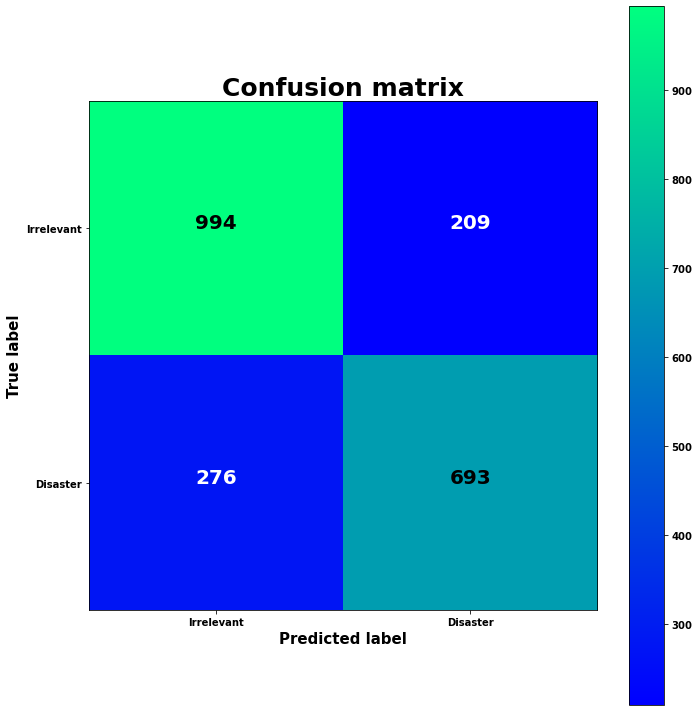

NN confusion matrix
[[994 209]
 [276 693]]


In [70]:
cm3 = confusion_matrix(y_test, y_predicted_NN.flatten())
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm3, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print("NN confusion matrix")
print(cm3)

## Oustanding question: How do you explain the disappointing performance of the ANN with the embedding layer to classify tweets compared to simplier encoding such as BoW or TF-IDF?

In [71]:
# Define the set of unique words that appear in the tweets
set_words_tweets = count_vectorizer.vocabulary_.keys()

# Define the set of words that are in the Word2Vec embedding (the model contains 300-dimensional 
# vectors for 300 000 words)
set_words_embedding = embedding_index.keys()

print(len(set_words_tweets))
print(len(set_words_embedding))

10000
300000


In [72]:
# Number of words that are in the tweet vocabulary but not in the embedding vocabulary
len(list(set(count_vectorizer.vocabulary_.keys()).difference(embedding_index.keys())))

3717

In [73]:
# List of words that are in the tweet vocabulary but not in the embedding vocabulary
list(set(count_vectorizer.vocabulary_.keys()).difference(embedding_index.keys()))

['marksmaponyane',
 'josebasedgod',
 'henry',
 'waimate',
 'jiahahahha',
 'dwight',
 'leelanau',
 'latechwatch',
 'gilbert23',
 'mi17',
 'nottingham',
 'youd',
 'kissimmee',
 'noooooooooooo',
 'murfreesboro',
 'juhasipila',
 'palestinians',
 'nj',
 'indah',
 'ww3',
 'kaduna',
 'kylekrenek',
 'mani',
 'matt_bez',
 '600',
 'mariahcarey',
 '2029',
 'gtgtgt',
 'kesabaran',
 'willinghearted',
 'slr',
 'infectiousdiseases',
 'willienelson',
 'yor',
 'insidecityhall',
 'np',
 'nochilllukehammings',
 '37',
 'jonvoyage',
 'kimacheson',
 'queensland',
 'wild_lionx3',
 'since3',
 'phillips',
 '2008',
 'cfc',
 'jetixrestored',
 'nkofoxy__siren',
 'kiwi_karyn',
 'nyndesigns',
 '36',
 'skie',
 'stuart',
 'mwlippert',
 'livescience',
 'laura',
 'kristindavis',
 'nuys',
 '5sosfamupdater',
 'kynespeace',
 '370',
 'jiwa',
 'jebbush',
 'starbucks',
 'malone',
 'dq',
 'jcomanse',
 'mccainenl',
 'navista7',
 '05th',
 'kornbread_icu',
 'jishin_e',
 'jasonpope2',
 'marlon',
 'multidimensiona',
 'zaibatsunews